## PCA Logistic Regression

In [1]:
# Import statements
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Display options
pd.set_option('display.max_columns', None)

In [2]:
hr_employee = pd.read_csv( './Data/PCA_HR_Employee.csv', delimiter = ",")
Attrition = pd.read_csv( './Data/Attrition.csv', delimiter = ",")

In [3]:
X = hr_employee
# Y = Attrition.values.ravel()
Y = Attrition

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1176, 29) (1176, 1)
(294, 29) (294, 1)


#### Functions

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
# Function:    gridSearcBestEstimator
# Input:       Classifier, parameters, cross validation
# Output:      Prints Best Estimator
# Returns:     Best Estimator
def gridSearcBestEstimator(model, params, cv):
    clf = model 
    gs = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', cv=cv, n_jobs=-1, )

    gs.fit(X_train, y_train.values.ravel())
    best_estimator = gs.best_estimator_
    
    print('Best Estimator:')
    print(best_estimator,'\n')
    
    #if model == DecisionTreeClassifier():
    #    best_estimator.get_depth()

    return best_estimator

In [6]:
# Function:    fitModel
# Input:       Classifier
# Returns:     Fitted Model
def fitModel(model):
    clf = model
    clf.fit(X_train, y_train.values.ravel())
    
    return clf

In [7]:
from sklearn.metrics import accuracy_score
# Function:    modelAccuracy
# Input:       Classifier with Best Estimator
# Output:      Prints Training & Testing Accuracy
# Returns:     Y Test Predictions
def modelAccuracy(model):
    clf = model
    
    # Make Train predictions
    y_train_pred = clf.predict(X_train)
    # Calculate accuracy score
    training_accuracy = accuracy_score(y_train, y_train_pred)
    print('Training Accuracy: ',training_accuracy)
    # confusionMatrixMetrics(y_train, y_pred)

    # Make Test predictions
    y_test_pred = clf.predict(X_test)
    # Calculate accuracy scores
    testing_accuracy = accuracy_score(y_test, y_test_pred)
    print('Testing Accuracy:  ',testing_accuracy)
    
    return y_test_pred

In [8]:
from sklearn.metrics import confusion_matrix
# Function:    confusionMatrix
# Input:       Training/Testing dataframe and predictions
# Output:      Prints Formatted Confusion Matrix
# Returns:     Confusion Matrix Array
# URL:         https://towardsdatascience.com/evaluating-machine-learning-classification-problems-in-python-5-1-metrics-that-matter-792c6faddf5
def confusionMatrix(true_test_train, pred):
    true = true_test_train
    
    cm = confusion_matrix(true, pred.round(), normalize=None)

    # Assigning columns names
    cm_df = pd.DataFrame(cm, 
                        columns = ['Predicted Negative', 'Predicted Positive'],
                        index = ['Actual Negative', 'Actual Positive'])
    
    # Printing Formatted Confusion Matrix
    print('\n',cm_df)
    
    return cm

In [9]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
# Function:    metrics
# Input:       confusion matrix array, true class values, predicted class values
# Output:      Prints Recall, Sensitivity, Precision, False Positive Rate, Balanced Accuracy & F1 Scores
def metrics(cm, true, pred):
    # Assign values from the confusion matrix to manually 
    # calculate Specificity and False Positive Rate 
    TP = cm[1][1]
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]

    # Recall
    recall = recall_score(true, pred)
    print('\nRecall:                  ', recall)
    # Sensitivity
    sensitivity = recall
    # Specificity
    specificity = (TN / float(TN + FP))
    print('Specificity:             ', specificity)
    # Precision
    precision = precision_score(true, pred)
    print('Precision:               ', precision)
    # False Positive Rate
    # fpr = (FP / float(TN + FP))
    # print ('False Positive Rate:     ', fpr)
    # Balanced Accuracy
    balanced_accuracy = (sensitivity + specificity)/2
    #balance_accuracy = metrics.balanced_accuracy_score(y_true, y_pred)
    print('Balanced Accuracy:       ', balanced_accuracy)
    # F1 Score Method 1: sklearn
    F1 = f1_score(true, pred)
    print('F1-Score:                ', F1)
    
    #return recall, specificity, precision, balanced_accuracy, F1, cm_df

### Logistic Regression Pre-processing
Scale Data

In [10]:
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Performance on default logistic regression model

In [11]:
# Fit Model to Default Classifier
lr_clf = fitModel(LogisticRegression())

# Calcualate Training and Testing Accuracy
y_test_pred = modelAccuracy(lr_clf)

# Print Confusion Matrix
cm = confusionMatrix(y_test, y_test_pred)

# Print Metrics
metrics(cm, y_test, y_test_pred)

Training Accuracy:  0.8622448979591837
Testing Accuracy:   0.8707482993197279

                  Predicted Negative  Predicted Positive
Actual Negative                 241                   7
Actual Positive                  31                  15

Recall:                   0.32608695652173914
Specificity:              0.9717741935483871
Precision:                0.6818181818181818
Balanced Accuracy:        0.6489305750350631
F1-Score:                 0.4411764705882353


#### Confusion Matrix for default model

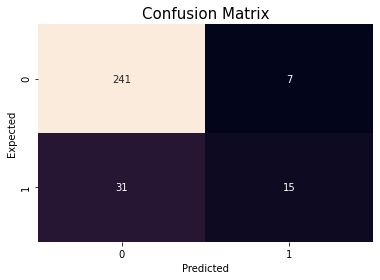

In [12]:
# Confusion Matrix
cm_plot =  pd.crosstab(index=y_test.values.ravel(), columns=y_test_pred, rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(cm_plot, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

### Cross Validation Setup

In [13]:
# Cross Validate
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

### GridSearch CV Logistic Regression

In [14]:
# Determine Best Estimator
params = dict(
    penalty = ['l1','l2'], #l1 lasso l2 ridge
    C = np.logspace(-3,3,7),
    solver=['lbfgs'],
    max_iter = [200,250,500,750]
)

# best_estimator = GridSearchCV(lr_clf, params,cv=10)
best_estimator = gridSearcBestEstimator(LogisticRegression(), params, cv)

# # Fit Model to best_estimator
lr_clf = fitModel(best_estimator)

# Calcualate Training and Testing Accuracy
y_test_pred = modelAccuracy(lr_clf)

# Print Confusion Matrix
cm = confusionMatrix(y_test, y_test_pred)

# Print Metrics
metrics(cm, y_test, y_test_pred)

Best Estimator:
LogisticRegression(C=100.0, max_iter=200) 

Training Accuracy:  0.8664965986394558
Testing Accuracy:   0.8741496598639455

                  Predicted Negative  Predicted Positive
Actual Negative                 241                   7
Actual Positive                  30                  16

Recall:                   0.34782608695652173
Specificity:              0.9717741935483871
Precision:                0.6956521739130435
Balanced Accuracy:        0.6598001402524545
F1-Score:                 0.46376811594202894


/opt/miniconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.                nan 0.                nan 0.
        nan 0.                nan 0.                nan 0.
        nan 0.                nan 0.                nan 0.12829475
        nan 0.12829475        nan 0.12829475        nan 0.12829475
        nan 0.33381286        nan 0.33381286        nan 0.33381286
        nan 0.33381286        nan 0.3913539         nan 0.3913539
        nan 0.3913539         nan 0.3913539         nan 0.39689087
        nan 0.39689087        nan 0.39689087        nan 0.39689087
        nan 0.39689087        nan 0.39689087        nan 0.39689087
        nan 0.39689087]
  warnings.warn(


### Confusion Matrix for Best Estimator

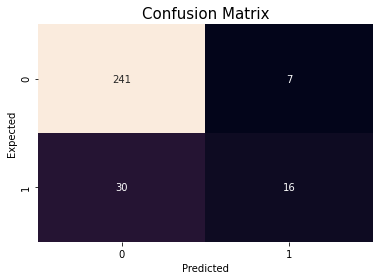

In [15]:
# Confusion Matrix
cm_plot =  pd.crosstab(index=y_test.values.ravel(), columns=y_test_pred, rownames=['Expected'], colnames=['Predicted'])
sns.heatmap(cm_plot, annot=True, square=False, fmt='', cbar=False)
plt.title("Confusion Matrix", fontsize = 15)
plt.show()

### Observations
 
